In [1]:
%matplotlib nbagg
import jungfrau_utils as ju
import numpy as np
import json
import os, glob
import time
from matplotlib import pyplot as plt
from matplotlib import cm
from scipy.optimize import curve_fit
from IPython.display import clear_output, display
import matplotlib.colors as colors

import h5py
from ipyfilechooser import FileChooser

from alvra_tools import *
from alvra_tools.channels import *
#from alvra_tools.channels_raw import *

## Next cells for a single scan

In [2]:
# Choose a pedestal file (usually located in /sf/alvra/data/*pgroup*/raw/JF_pedestals) 
# if you do not want to use the closest in time
# If 'None' the closest in time is selected

# pedestal_file = "/sf/alvra/data/p17983/res/JF_pedestals/pedestal_20190727_2115.JF02T09V02.res.h5"
pedestal_file = None

In [4]:
scan_name ="RuFoil_RIXS/"

DIR = "/sf/alvra/data/p18741/raw/scan_data/" + scan_name

!ls -lah -t $DIR  | grep JF

!hostname

listfile = os.listdir(DIR)
number_files = len(listfile)
print ("There are",number_files,"files in the folder", DIR)

-rw-r--r--. 1 root p18741  22G Nov 25 17:34 run_000932.JF02T09V02.h5
-rw-r--r--. 1 root p18741  22G Nov 25 17:33 run_000952.JF02T09V02.h5
-rw-r--r--. 1 root p18741  22G Nov 25 17:33 run_000949.JF02T09V02.h5
-rw-r--r--. 1 root p18741  22G Nov 25 17:33 run_000931.JF02T09V02.h5
-rw-r--r--. 1 root p18741  22G Nov 25 17:33 run_000917.JF02T09V02.h5
-rw-r--r--. 1 root p18741  22G Nov 25 17:32 run_000929.JF02T09V02.h5
-rw-r--r--. 1 root p18741  22G Nov 25 17:32 run_000912.JF02T09V02.h5
-rw-r--r--. 1 root p18741  22G Nov 25 17:32 run_000947.JF02T09V02.h5
-rw-r--r--. 1 root p18741  22G Nov 25 17:32 run_000950.JF02T09V02.h5
-rw-r--r--. 1 root p18741  22G Nov 25 17:31 run_000948.JF02T09V02.h5
-rw-r--r--. 1 root p18741  22G Nov 25 17:31 run_000933.JF02T09V02.h5
-rw-r--r--. 1 root p18741  22G Nov 25 17:31 run_000923.JF02T09V02.h5
-rw-r--r--. 1 root p18741  22G Nov 25 17:31 run_000916.JF02T09V02.h5
-rw-r--r--. 1 root p18741  22G Nov 25 17:30 run_000934.JF02T09V02.h5
-rw-r--r--. 1 root p18741  22G Nov

/sf/alvra/data/p18741/raw/scan_data/RuFoil_RIXS/run_000946.JF02T09V02.h5
Auto-located gain file: /sf/alvra/config/jungfrau/gainMaps/JF02T09V02/gains.h5
Auto-located pedestal file: /sf/alvra/data/p18741/raw/JF_pedestals/pedestal_20200202_2046.JF02T09V02.res.h5
jungfrau file: 17:24 25.11.2020
pedestal file: 08:57 26.11.2020
    mtime difference: -15:32:21.540456
Total number of images = 2500
Shape of image: (514, 9318)
It took 5.27 seconds to process this file


<IPython.core.display.Javascript object>


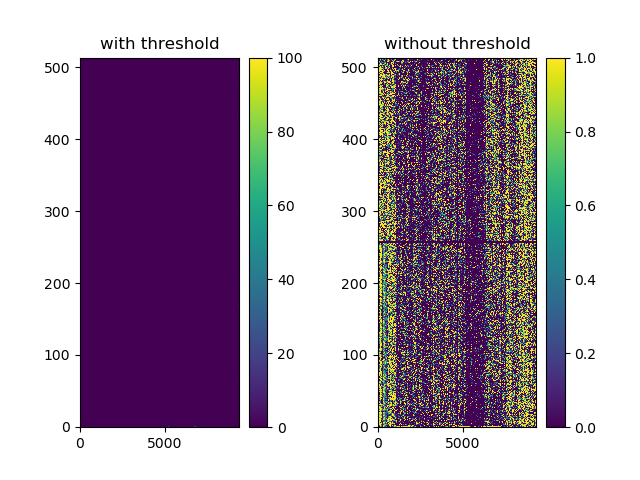

In [5]:
# First we load the first images of a file to check if everything is fine with the pedestal &  files (check high True or False)
# We can see also how the ROIs look like (will be useful later)

fileName = "run_000946"

####################################################################
clock = Clock()

fileName = fileName + ".JF02T09V02.h5"

print(DIR + fileName)

nframes = 10
#nframes = images.shape[0]
total = 0
total_thr = 0

with ju.File(DIR + fileName, pedestal_file=pedestal_file) as juf:
    pulse_ids = juf["pulse_id"][:]
    print ('Total number of images = {}'.format(len(pulse_ids)))
    for i in range(nframes):
        image = juf[i, :]
        image_thr = image.copy()
        image_thr[image < 2] = 0
        total_thr += image_thr
        total += image
        #total /= nframes
    
print ("Shape of image: {}".format(total_thr.shape))
print ("It took", clock.tick(), "seconds to process this file")

#roi = [[225, 325], [6950, 7075]]
#roi = [[225, 325], [7900, 8450]]
#roi = [[0, total_corr.shape[0]], [0, total_corr.shape[1]]]

plt.figure()
plt.subplots_adjust(wspace=0.5)
plt.subplot(121)
plt.imshow(total_thr, origin="lower", aspect='auto', vmin=0, vmax=100)
plt.title("with threshold")
plt.colorbar()
plt.subplot(122)
plt.imshow(total, origin="lower", aspect='auto', vmin=0, vmax=1)
plt.title("without threshold")
plt.colorbar()
plt.show()


<IPython.core.display.Javascript object>


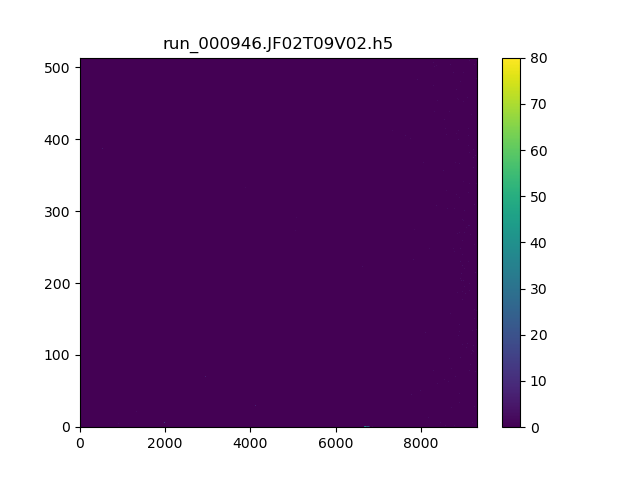

In [6]:
plt.figure()
plt.imshow(total_thr, origin="lower", aspect='auto', vmin=0, vmax=80)
plt.title(fileName)
plt.colorbar()
plt.show()

# Now load all images with ROIs (single file)

In [11]:
files = ["run_000946"] # can be a list of files, counts will be summed up


roi1 = (5000, 5150, 220, 290) # Ru La ROIs
roi2 = (5000, 5150, 290, 360) 

roi3 = (2000, 2200, 10, 210)   # Lb _not set correctly!
roi4 = (2000, 2200, 230, 430)   # Kb_background

threshold_low = 2.0
threshold_high = 10

#Timezero = 194.6   # position of Timezero on PP delay (in mm!)
######################################################################################
start_time = time.time()
spectrum_roi1 = 0
spectrum_roi2 = 0
spectrum_roi3 = 0
spectrum_roi4 = 0
energy_eV = 0
Delay_mm_single = 0
        
for f in files:
    JF_single_file = DIR + f + ".JF02T09V02.h5"
    BS_single_file = DIR + f + ".BSREAD.h5"
    print("Processing file %s" % (JF_single_file))
    
#    photon_range = (6, 7)

    nshots = 100  # put this to None for ALL images
    #nshots = None

    images_roi1, images_roi2, images_roi3, images_roi4, pids = \
    load_crop_JF_data(JF_single_file, roi1, roi2, roi3, roi4, pedestal_file=pedestal_file, nshots=nshots)
    
#    delay, pids = load_single_channel_pulseID(BS_single_file, channel_delay, 50)
#    delay = [x for x in delay if (x > 0)]
#    Delay_mm_single = np.mean(delay)
#    Delay_ps_single = (Delay_mm_single - Timezero)*2/(3e8*1e3*1e-12) # in ps, change to right t0 !
    
#    Izero_pump, Izero_unpump, energy_eV, pulseIDs = \
#    load_FEL_pp_pulseID(BS_single_file, channel_energy, 50, 25, 50)  
    
    images_roi1_thr = images_roi1.copy()
    images_roi1_thr[images_roi1 < threshold_low] = 0
    images_roi1_thr[images_roi1 > threshold_high] = 0
#   images_ON_roi1 = convert_to_photon_num_range(images_ON_roi1)

    images_roi2_thr = images_roi2.copy()
    images_roi2_thr[images_roi2 < threshold_low] = 0
    images_roi2_thr[images_roi2 > threshold_high] = 0
#   images_ON_roi1 = convert_to_photon_num_range(images_ON_roi1)

    images_roi3_thr = images_roi3.copy()
    images_roi3_thr[images_roi3 < threshold_low] = 0
    images_roi3_thr[images_roi3 > threshold_high] = 0
#   images_ON_roi1 = convert_to_photon_num_range(images_ON_roi1)

    images_roi4_thr = images_roi4.copy()
    images_roi4_thr[images_roi4 < threshold_low] = 0
    images_roi4_thr[images_roi4 > threshold_high] = 0
#   images_ON_roi1 = convert_to_photon_num_range(images_ON_roi1)


    spectrum_roi1  += images_roi1_thr.sum(axis = 1).sum(axis = 0)
    spectrum_roi2  += images_roi2_thr.sum(axis = 1).sum(axis = 0)
    spectrum_roi3  += images_roi3_thr.sum(axis = 1).sum(axis = 0)
    spectrum_roi4  += images_roi4_thr.sum(axis = 1).sum(axis = 0)

print ("Job done! It took", round((time.time() - start_time), 2), "seconds to process", len(files), "file" if len(files) == 1 else "files")

Processing file /sf/alvra/data/p18741/raw/scan_data/RuFoil_RIXS/run_000946.JF02T09V02.h5
Auto-located gain file: /sf/alvra/config/jungfrau/gainMaps/JF02T09V02/gains.h5
Auto-located pedestal file: /sf/alvra/data/p18741/raw/JF_pedestals/pedestal_20200202_2046.JF02T09V02.res.h5
jungfrau file: 17:24 25.11.2020
pedestal file: 08:57 26.11.2020
    mtime difference: -15:32:21.540456
Job done! It took 3.12 seconds to process 1 file


<IPython.core.display.Javascript object>


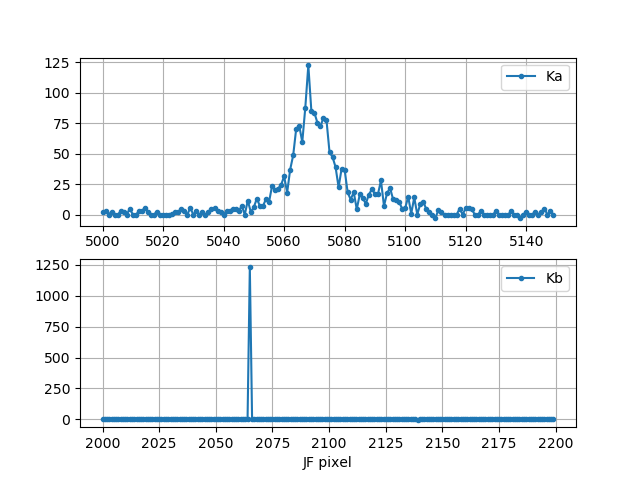

In [12]:
spectrum_bkg_roi1 = spectrum_roi1  - spectrum_roi2
err_spectrum_ro1 = np.sqrt(spectrum_roi1)
err_bkg_2 = np.sqrt(spectrum_roi2)

spectrum_bkg_roi3 = spectrum_roi3 - spectrum_roi4
err_spectrum_roi3 = np.sqrt(spectrum_roi3)
err_bkg_4 = np.sqrt(spectrum_roi4)


bin1_ = 1   # change the bin size if wanted, 1 is every pixel
bin3_ = 1

spectrum_bkg_1 = spectrum_bkg_roi1.copy()
spectrum_bkg_3 = spectrum_bkg_roi3.copy()
x_axis_1 = np.arange(roi1[0], roi1[1])
x_axis_3 = np.arange(roi3[0], roi3[1])


spectrum_rebin1  = bin_sum(spectrum_bkg_1,  bin1_)
x_axis_rebin1 = bin_mean(x_axis_1, bin1_)
spectrum_rebin3  = bin_sum(spectrum_bkg_3,  bin3_)
x_axis_rebin3 = bin_mean(x_axis_3, bin3_)


#low_err_Ka= (spectrum_rebin1)-np.sqrt(spectra_on_err1**2+spectra_off_err1**2)
#high_err_Kb= (spectra_on_rebin1 - spectra_off_rebin1)+np.sqrt(spectra_on_err1**2+spectra_off_err1**2)

#spectrumAllOutFoc=spectra_on_rebin1 + spectra_off_rebin1
plt.figure()
plt.subplot(211)
#plt.title(scan_name + ", delay = {} ps".format(str(np.round(Delay_ps_single,3))))
plt.plot(x_axis_rebin1, spectrum_rebin1, label="Ka", marker='.')
plt.legend(loc="best")
plt.grid()

plt.subplot(212)
#plt.title(scan_name + ", delay = {} ps".format(str(np.round(Delay_ps_single,3))))
plt.plot(x_axis_rebin3, spectrum_rebin3, label="Kb", marker='.')
plt.legend(loc="best")
plt.grid()

#plt.title(jf_file)
plt.xlabel("JF pixel")
plt.show()

# Next cells to sum up identical runs in the same folder (NOT FOR SCANS)

In [15]:
datalist_BS = glob(DIR + "*.BSREAD.h5")
datalist_BS = sorted(datalist_BS)
datalist_JF = glob(DIR + "*.JF02T09V02.h5")
datalist_JF = sorted(datalist_JF)

number_files_BS = len(datalist_BS)
number_files_JF = len(datalist_JF)

print ("Found {} BS files and {} JF files".format(len(datalist_BS), len(datalist_JF)))

Found 41 BS files and 41 JF files


In [ ]:
datalist_BS = glob.glob(DIR + "*.BSREAD.h5")
datalist_BS = sorted(datalist_BS)
datalist_JF = glob.glob(DIR + "*.JF02T09V02.h5")
datalist_JF = sorted(datalist_JF)

number_files_BS = len(datalist_BS)
number_files_JF = len(datalist_JF)

print ("Found {} BS files and {} JF files".format(len(datalist_BS), len(datalist_JF)))

spectrum_final1 = 0
spectrum_final3 = 0

roi1 = (5000, 5150, 220, 290) # Ru La ROIs
roi2 = (5000, 5150, 290, 360) 

roi3 = (2000, 2200, 10, 210)   # Lb _not set correctly!
roi4 = (2000, 2200, 230, 430)   # Kb_background

threshold_low = 2.0
threshold_high = 10

######################################################################################
clock = Clock()
for file in datalist_JF:
    fileName = file
    print (fileName)
    exists = os.path.isfile(fileName)
    if exists:
        print("Processing file %s" % (fileName))
        #nshots = 10000  # put this to None for ALL images
        nshots = None
        
        images_roi1, images_roi2, images_roi3, images_roi4, pids = \
        load_crop_JF_data(fileName, roi1, roi2, roi3, roi4, pedestal_file=pedestal_file, nshots=nshots)
        
        delay, pids = load_single_channel_pulseID(BS_single_file, channel_delay, 50)
        delay = [x for x in delay if (x > 0)]
        Delay_mm_single = np.mean(delay)
        Delay_ps_single = (Delay_mm_single - Timezero)*2/(3e8*1e3*1e-12) # in ps, change to right t0 !
    
        images_roi1_thr = images_roi1.copy()
        images_roi1_thr[images_roi1 < threshold_low] = 0
        images_roi1_thr[images_roi1 > threshold_high] = 0
#        images_ON_roi1 = convert_to_photon_num_range(images_ON_roi1)

        images_roi2_thr = images_roi2.copy()
        images_roi2_thr[images_roi2 < threshold_low] = 0
        images_roi2_thr[images_roi2 > threshold_high] = 0
#        images_ON_roi1 = convert_to_photon_num_range(images_ON_roi1)

        images_roi3_thr = images_roi3.copy()
        images_roi3_thr[images_roi3 < threshold_low] = 0
        images_roi3_thr[images_roi3 > threshold_high] = 0
#        images_ON_roi1 = convert_to_photon_num_range(images_ON_roi1)

        images_roi4_thr = images_roi4.copy()
        images_roi4_thr[images_roi4 < threshold_low] = 0
        images_roi4_thr[images_roi4 > threshold_high] = 0
#        images_ON_roi1 = convert_to_photon_num_range(images_ON_roi1)
                
        spectrum_roi1  = images_roi1_thr.sum(axis = 1).sum(axis = 0)
        spectrum_roi2  = images_roi2_thr.sum(axis = 1).sum(axis = 0)
        spectrum_roi3  = images_roi3_thr.sum(axis = 1).sum(axis = 0)
        spectrum_roi4  = images_roi4_thr.sum(axis = 1).sum(axis = 0)
        
        
    print ("It took", clock.tick(), "seconds to process this file")

    spectrum_final1 += spectrum_roi2 - spectrum_roi1
    spectrum_final3 += spectrum_roi3 - spectrum_roi4
        
print ("\nJob done! It took", clock.tock(), "seconds to process", number_files, "file(s)")

In [ ]:
spectrum_bkg_roi1 = spectrum_final1  
err_spectrum_ro1 = np.sqrt(spectrum_roi1)

spectrum_bkg_roi3 = spectrum_final3
err_spectrum_roi3 = np.sqrt(spectrum_roi3)


bin1_ = 1   # change the bin size if wanted, 1 is every pixel
bin3_ = 1

spectrum_bkg_1 = spectrum_bkg_roi1.copy()
spectrum_bkg_3 = spectrum_bkg_roi3.copy()
x_axis_1 = np.arange(roi1[0], roi1[1])
x_axis_3 = np.arange(roi3[0], roi3[1])


spectrum_rebin1  = bin_sum(spectrum_bkg_1,  bin1_)
x_axis_rebin1 = bin_mean(x_axis_1, bin1_)
spectrum_rebin3  = bin_sum(spectrum_bkg_3,  bin3_)
x_axis_rebin3 = bin_mean(x_axis_3, bin3_)


#low_err_Ka= (spectrum_rebin1)-np.sqrt(spectra_on_err1**2+spectra_off_err1**2)
#high_err_Kb= (spectra_on_rebin1 - spectra_off_rebin1)+np.sqrt(spectra_on_err1**2+spectra_off_err1**2)

#spectrumAllOutFoc=spectra_on_rebin1 + spectra_off_rebin1
plt.figure()
plt.subplot(211)
#plt.title(scan_name + ", delay = {} ps".format(str(np.round(Delay_ps_single,3))))
plt.plot(x_axis_rebin1, spectrum_rebin1, label="Ka", marker='.')
plt.legend(loc="best")
plt.grid()

plt.subplot(212)
#plt.title(scan_name + ", delay = {} ps".format(str(np.round(Delay_ps_single,3))))
plt.plot(x_axis_rebin3, spectrum_rebin3, label="Kb", marker='.')
plt.legend(loc="best")
plt.grid()

#plt.title(jf_file)
plt.xlabel("JF pixel")
plt.show()

# New script in the next cell (scans) 

In [19]:
fc = FileChooser('/sf/alvra/data/p18741/raw/scan_info/')
fc.use_dir_icons = True
display(fc)

FileChooser(path='/sf/alvra/data/p18741/raw/scan_info', filename='', show_hidden='False')

In [22]:

roi1 = (5000, 5150, 220, 290) # Ru La ROIs
roi2 = (5000, 5150, 290, 360) 

roi3 = (2000, 2200, 10, 210)   # Lb _not set correctly!
roi4 = (2000, 2200, 230, 430)   # Kb_background

threshold_low = 2.0
threshold_high = 10

######################################################################################

json_file = fc.selected
scan_data = load_scan_data(json_file)

Energy_eV = []
Delay_mm = []
XAS_roi1 = []
XAS_roi3 = []
calibration = []
RIXS_roi1 = []
RIXS_roi3 = []

clock = Clock()
num_scan_files = len(scan_data)
print("\nProcessing", num_scan_files, "total files")

for i, (bs, fn1) in enumerate(scan_data):
#for i in range(0,4):
    clear_output(wait=True)
    
    print("\nFile", i+1, "of", num_scan_files, ": Processing:", fn1.split("/")[-1])
    
    spectrum_roi1 = 0
    spectrum_roi2 = 0
    spectrum_roi3 = 0
    spectrum_roi4 = 0
    
    #nshots = 10000  # put this to None for ALL images
    nshots = 10
    
    images_roi1, images_roi2, images_roi3, images_roi4, pids = \
    load_crop_JF_data(fn1, roi1, roi2, roi3, roi4, pedestal_file=pedestal_file, nshots=nshots)
    
    energy, pids = load_single_channel_pulseID(bs, channel_energy, 50)
    energy = [x for x in energy if (x > 0)]
    Energy_eV.append(np.mean(energy))
    
    delay, pids = load_single_channel_pulseID(bs, channel_delay_topas, 50)
    delay = [x for x in delay if (x > 0)]
    Delay_mm.append(np.mean(delay))
    
    images_roi1_thr = images_roi1.copy()
    images_roi1_thr[images_roi1 < threshold_low] = 0
    images_roi1_thr[images_roi1 > threshold_high] = 0

    images_roi2_thr = images_roi2.copy()
    images_roi2_thr[images_roi2 < threshold_low] = 0
    images_roi2_thr[images_roi2 > threshold_high] = 0

    images_roi3_thr = images_roi3.copy()
    images_roi3_thr[images_roi3 < threshold_low] = 0
    images_roi3_thr[images_roi3 > threshold_high] = 0

    images_roi4_thr = images_roi4.copy()
    images_roi4_thr[images_roi4 < threshold_low] = 0
    images_roi4_thr[images_roi4 > threshold_high] = 0

    
    spectrum_roi1  = images_roi1_thr.sum(axis = 1).sum(axis = 0)
    spectrum_roi2  = images_roi2_thr.sum(axis = 1).sum(axis = 0)
    spectrum_roi3  = images_roi3_thr.sum(axis = 1).sum(axis = 0)
    spectrum_roi4  = images_roi4_thr.sum(axis = 1).sum(axis = 0)
    
    XAS_roi1.append(np.abs((spectrum_roi1 - spectrum_roi2).sum()))
    XAS_roi3.append(np.abs((spectrum_roi3 - spectrum_roi4).sum()))
    #print (np.argmax(spectrum_roi3 - spectrum_roi4))
    calibration.append(np.argmax(spectrum_roi1 - spectrum_roi2))

    RIXS_roi1.append(spectrum_roi1 - spectrum_roi2)
    RIXS_roi3.append(spectrum_roi3 - spectrum_roi4)
    
    
    print ("It took", clock.tick(), "seconds to process this file")

Energy_eV = np.array(Energy_eV)
Delay_mm = np.array(Delay_mm)
XAS_roi1 = np.array(XAS_roi1)
calibration = np.array(calibration)
RIXS_roi1 = np.array(RIXS_roi1)

print ("\nJob done! It took", clock.tock(), "seconds to process", num_scan_files, "file(s)")




File 41 of 41 : Processing: run_000952.JF02T09V02.h5
Auto-located gain file: /sf/alvra/config/jungfrau/gainMaps/JF02T09V02/gains.h5
Auto-located pedestal file: /sf/alvra/data/p18741/raw/JF_pedestals/pedestal_20200202_2046.JF02T09V02.res.h5
jungfrau file: 17:33 25.11.2020
pedestal file: 08:57 26.11.2020
    mtime difference: -15:23:12.668956
It took 2.21 seconds to process this file

Job done! It took 82.06 seconds to process 41 file(s)


<IPython.core.display.Javascript object>


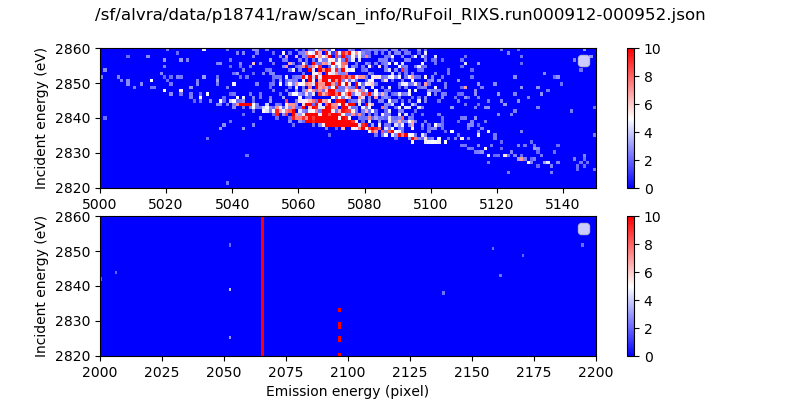

No handles with labels found to put in legend.
No handles with labels found to put in legend.


In [27]:
plt.figure(figsize=(8,4))
plt.suptitle(json_file, fontsize=12)
plt.subplot(211)
plt.imshow(RIXS_roi1, label="Ka", aspect = 'auto', cmap = "bwr", origin ="lower", \
           extent=[roi1[0], roi1[1], Energy_eV[0], Energy_eV[-1]], vmin=0, vmax=10)
plt.xlabel("Emission energy (pixel)")
plt.ylabel("Incident energy (eV)")
plt.colorbar()
plt.legend(loc="best")

plt.subplot(212)
plt.imshow(RIXS_roi3, aspect = 'auto', cmap = "bwr", label="Kb", origin ="lower", \
           extent=[roi3[0], roi3[1], Energy_eV[0], Energy_eV[-1]], vmin=0, vmax=10)
plt.xlabel("Emission energy (pixel)")
plt.ylabel("Incident energy (eV)")
plt.legend(loc="best")
plt.colorbar()
plt.show()


<IPython.core.display.Javascript object>


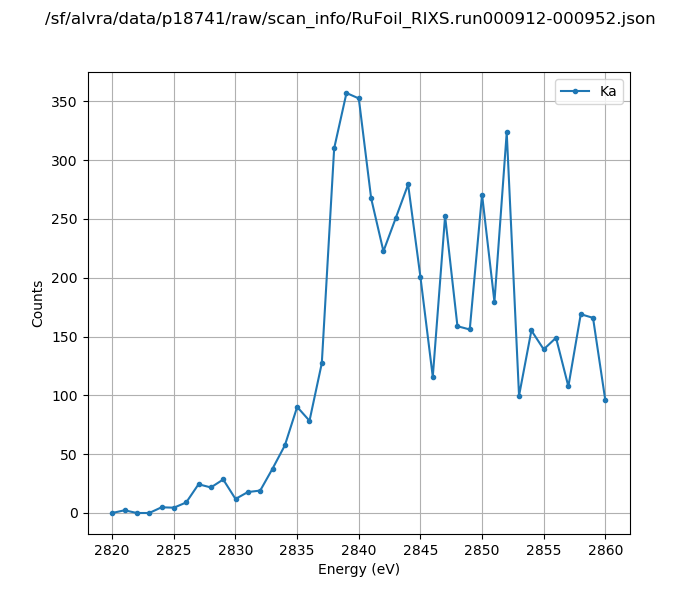

In [29]:
plt.figure(figsize=(7,6))
plt.suptitle(json_file, fontsize=12)

plt.plot(Energy_eV, XAS_roi1,label="Ka", marker='.')
plt.xlabel("Energy (eV)")
plt.ylabel("Counts")
plt.legend(loc="best")
plt.grid()

plt.show()

In [ ]:
def edge_removal(module_edge, roi_removal, array):
    index_edge = module_edge - roi_removal[0]
    array_input = array.copy()
    print (array[index_edge-1:index_edge+3])
    array[index_edge] = array[index_edge-1]/2
    array[index_edge-1] = array[index_edge-1]/2

    array[index_edge+1] = array[index_edge+2]/2
    array[index_edge+2] = array[index_edge+2]/2 
    print (array[index_edge-1:index_edge+3])
    return array, array_input

In [ ]:
spectrum_ON_roi1, spectrum_ON_roi1_orig = edge_removal(6472, roi1, spectrum_ON_roi1) 
spectrum_OFF_roi1, spectrum_OFF_roi1_orig = edge_removal(6472, roi1, spectrum_OFF_roi1) 